In [115]:
!pip install anndata

You should consider upgrading via the '/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/bin/python -m pip install --upgrade pip' command.


In [1]:
%load_ext autoreload
%autoreload 2
import h5py
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
rng=np.random.default_rng()
import tqdm.notebook
import pickle
%matplotlib inline
import sys
import ipywidgets
import sklearn.neighbors
from scipy.sparse import csr_matrix

original_url= "https://datadryad.org/stash/downloads/file_stream/67671"
csv_location='data/spatial/moffit_merfish/original_file.csv'
h5ad_location='data/spatial/moffit_merfish/original_file.h5ad'
connectivity_matrix_template='data/spatial/moffit_merfish/connectivity_%dneighbors.h5ad'
genetypes_location='/data/spatial/moffit_merfish/genetypes.pkl'

# download csv

In [117]:
import requests

with open(csv_location, "wb") as csvf:
    csvf.write(requests.get(original_url).content)

# munge into hdf5 file

In [118]:
dataframe = pd.read_csv(csv_location)

dct={}
for colnm, dtype in zip(dataframe.keys()[:9], dataframe.dtypes[:9]):
    if dtype.kind == "O":
        dct[colnm]=np.require(dataframe[colnm], dtype="U36")
    else:
        dct[colnm]=np.require(dataframe[colnm])
expression = np.array(dataframe[dataframe.keys()[9:]]).astype(np.float16)
gene_names = np.array(dataframe.keys()[9:], dtype="U80")
cellid=dct.pop('Cell_ID')

ad=anndata.AnnData(
    X=expression,
    var=pd.DataFrame(index=gene_names),
    obs=pd.DataFrame(dct,index=cellid)
)

ad.write_h5ad(h5ad_location)

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Animal_sex' as categorical
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Behavior' as categorical
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` pa

# supplement hdf5 file with a column indicating "tissue id" for each cell

In [119]:
ad=anndata.read_h5ad(h5ad_location)
animal_ids=np.unique(ad.obs['Animal_ID'])
bregmas=np.unique(ad.obs['Bregma'])
tissue_id=np.zeros(len(ad),dtype=int)
n_tissues=0
    
for aid in animal_ids:
    for bregma in bregmas:
        good=(ad.obs['Animal_ID']==aid)&(ad.obs['Bregma']==bregma)
        if np.sum(good)>0:
            tissue_id[good]=n_tissues
            n_tissues+=1
ad.obs['Tissue_ID']=tissue_id
ad.write_h5ad(h5ad_location)

# create global graph (using 3 nearest neigbors)

In [2]:
ad=anndata.read_h5ad(h5ad_location)
row=np.zeros(0,dtype=int)
col=np.zeros(0,dtype=int)
nneigh=0
radius=70
mode="neighbors"

for tid in tqdm.notebook.tqdm(np.unique(ad.obs['Tissue_ID'])):
    good=ad.obs['Tissue_ID']==tid
    pos=np.array(ad.obs[good][['Centroid_X','Centroid_Y']])
    if mode == "neighbors":
        if nneigh == 0:
            E = csr_matrix(np.eye(pos.shape[0]))
        else:
            p=sklearn.neighbors.BallTree(pos)
            E=sklearn.neighbors.kneighbors_graph(pos,nneigh,mode='connectivity')
    if mode == "rad":
        p=sklearn.spatial.cKDTree(pos)
        E=p.query_ball_point(pos, r=radius, return_sorted=False)
    idxs=np.where(good)[0]
    col=np.r_[col,idxs[E.tocoo().col]]
    row=np.r_[row,idxs[E.tocoo().row]]
    
E=sp.sparse.coo_matrix((np.ones(len(col)),(row,col)),shape=(len(ad),len(ad))).tocsr()
if mode == "neighbors":
    anndata.AnnData(E).write_h5ad(connectivity_matrix_template%nneigh)
if mode == "rad":
    anndata.AnnData(E).write_h5ad(connectivity_matrix_template%radius)

  0%|          | 0/181 [00:00<?, ?it/s]

# write down ligand/receptor sets

In [2]:
ligands=np.array(['Cbln1', 'Cxcl14', 'Cbln2', 'Vgf', 'Scg2', 'Cartpt', 'Tac2',
       'Bdnf', 'Bmp7', 'Cyr61', 'Fn1', 'Fst', 'Gad1', 'Ntng1', 'Pnoc',
       'Selplg', 'Sema3c', 'Sema4d', 'Serpine1', 'Adcyap1', 'Cck', 'Crh',
       'Gal', 'Gnrh1', 'Nts', 'Oxt', 'Penk', 'Sst', 'Tac1', 'Trh', 'Ucn3'])

receptors=np.array(['Crhbp', 'Gabra1', 'Gpr165', 'Glra3', 'Gabrg1', 'Adora2a',
       'Avpr1a', 'Avpr2', 'Brs3', 'Calcr', 'Cckar', 'Cckbr', 'Crhr1',
       'Crhr2', 'Galr1', 'Galr2', 'Grpr', 'Htr2c', 'Igf1r', 'Igf2r',
       'Kiss1r', 'Lepr', 'Lpar1', 'Mc4r', 'Npy1r', 'Npy2r', 'Ntsr1',
       'Oprd1', 'Oprk1', 'Oprl1', 'Oxtr', 'Pdgfra', 'Prlr', 'Ramp3',
       'Rxfp1', 'Slc17a7', 'Slc18a2', 'Tacr1', 'Tacr3', 'Trhr'])

response_genes=np.array(['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Fos', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2'])
cell_types = [
        "Ambiguous",
        "Astrocyte",
        "Endothelial 1",
        "Endothelial 2",
        "Endothelial 3",
        "Ependymal",
        "Excitatory",
        "Inhibitory",
        "Microglia",
        "OD Immature 1",
        "OD Immature 2",
        "OD Mature 1",
        "OD Mature 2",
        "OD Mature 3",
        "OD Mature 4",
        "Pericytes",
    ]

In [13]:
with open(genetypes_location,'wb') as f:
    pickle.dump(dict(ligands=ligands,receptors=receptors,response_genes=response_genes),f)

PermissionError: [Errno 13] Permission denied: '/data/spatial/moffit_merfish/genetypes.pkl'

# run a simple experiment: use ligands and receptors to predict response genes in excitatory cells, with a linear model

In [3]:
# load data
nneigh=30
radius=70
mode="neighbors"
ad=anndata.read_h5ad(h5ad_location)
connectivity_matrix=anndata.read_h5ad(connectivity_matrix_template%nneigh).X
gene_lookup={x:i for (i,x) in enumerate(ad.var.index)}

with open(genetypes_location,'rb') as f:
    genetypes=pickle.load(f)

In [4]:
# onehot encode cell classes
def oh_encode(lst):
    lst=np.array(lst)
    group_names=np.unique(lst)
    group_indexes=np.zeros((len(lst),len(group_names)),dtype=bool)
    for i,nm in enumerate(group_names):
        group_indexes[lst==nm,i]=True
    return group_names,group_indexes
cell_classes,cell_class_onehots=oh_encode(ad.obs['Cell_class'])

In [5]:
# a function to construct a prediction problem for a subset of cells

def construct_problem(mask,target_gene,neighbor_genes,self_genes,filter_excitatory=False):
    '''
    mask -- set of cells
    target_gene -- gene to predict
    neighbor_genes -- names of genes which will be read from neighbors
    self_genes -- names of genes which will be read from target cell
    '''
    
    feature_names = []
    
    # load subset of data relevant to mask
    local_processed_expression=np.log1p(ad.X[mask].astype(float)) # get expression on subset of cells
    local_edges=connectivity_matrix[mask][:,mask]   # get edges for subset
    
    selfset_idxs=[gene_lookup[x] for x in self_genes] # collect the column indexes associated with them
    selfset_exprs = local_processed_expression[:,selfset_idxs] # collect ligand and receptor expressions
    
    feature_names += [x for x in self_genes]
    
    neighborset_idxs=[gene_lookup[x] for x in neighbor_genes] # collect the column indexes associated with them
    neighset_exprs = local_processed_expression[:,neighborset_idxs] # collect ligand and receptor expressions
    
    feature_names += [x + " from Neighbors" for x in neighbor_genes]
    
    n_neighs=(local_edges@np.ones(local_edges.shape[0]))
    print(n_neighs)
    neigh_avgs = (local_edges@neighset_exprs) / n_neighs[:,None] # average ligand/receptor for neighbors
    
    neigh_cellclass_avgs = (local_edges@cell_class_onehots[mask]) / n_neighs[:,None] # celltype simplex
    
    feature_names += [f"Cell Class {cell_types[x]}" for x in range(16)]
    
    positions=np.array(ad.obs[['Centroid_X','Centroid_Y','Bregma']])[mask] # get positions
    
    feature_names += ['Centroid_X','Centroid_Y','Bregma']
    
    covariates=np.c_[selfset_exprs,neigh_avgs,neigh_cellclass_avgs,positions] # collect all covariates
    predict = local_processed_expression[:,gene_lookup[target_gene]] # collect what we're supposed to predict
    
    print(selfset_exprs.shape, neigh_avgs.shape, neigh_cellclass_avgs.shape, positions.shape)
    
    if filter_excitatory:
    
        excites=(ad.obs['Cell_class']=='Excitatory')[mask] # get the subset of these cells which are excitatory
        covariates=covariates[excites] # subset to excites
        predict=predict[excites]       # subset to excites
    
    return covariates,predict,feature_names

In [36]:
neighset=genetypes['ligands']
oset=np.r_[genetypes['ligands'],genetypes['receptors']]
# oset=neighset

# oset=[]
# neighset=[]

trainX,trainY,feature_names=construct_problem((ad.obs['Animal_ID']>=2)&(ad.obs['Animal_ID']<=4),'Th',neighset,oset)
testX,testY,feature_names=construct_problem((ad.obs['Animal_ID']==1),'Th',neighset,oset)

print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

# whiten covariates
# mu=np.mean(trainX,axis=0)
# sig=np.std(trainX,axis=0)
# trainX=(trainX-mu)/sig
# testX=(testX-mu)/sig

[30. 30. 30. ... 30. 30. 30.]
(131693, 71) (131693, 31) (131693, 16) (131693, 3)
[30. 30. 30. ... 30. 30. 30.]
(73655, 71) (73655, 31) (73655, 16) (73655, 3)
(131693, 121) (131693,)
(73655, 121) (73655,)


In [37]:
feature_names

['Cbln1',
 'Cxcl14',
 'Cbln2',
 'Vgf',
 'Scg2',
 'Cartpt',
 'Tac2',
 'Bdnf',
 'Bmp7',
 'Cyr61',
 'Fn1',
 'Fst',
 'Gad1',
 'Ntng1',
 'Pnoc',
 'Selplg',
 'Sema3c',
 'Sema4d',
 'Serpine1',
 'Adcyap1',
 'Cck',
 'Crh',
 'Gal',
 'Gnrh1',
 'Nts',
 'Oxt',
 'Penk',
 'Sst',
 'Tac1',
 'Trh',
 'Ucn3',
 'Crhbp',
 'Gabra1',
 'Gpr165',
 'Glra3',
 'Gabrg1',
 'Adora2a',
 'Avpr1a',
 'Avpr2',
 'Brs3',
 'Calcr',
 'Cckar',
 'Cckbr',
 'Crhr1',
 'Crhr2',
 'Galr1',
 'Galr2',
 'Grpr',
 'Htr2c',
 'Igf1r',
 'Igf2r',
 'Kiss1r',
 'Lepr',
 'Lpar1',
 'Mc4r',
 'Npy1r',
 'Npy2r',
 'Ntsr1',
 'Oprd1',
 'Oprk1',
 'Oprl1',
 'Oxtr',
 'Pdgfra',
 'Prlr',
 'Ramp3',
 'Rxfp1',
 'Slc17a7',
 'Slc18a2',
 'Tacr1',
 'Tacr3',
 'Trhr',
 'Cbln1 from Neighbors',
 'Cxcl14 from Neighbors',
 'Cbln2 from Neighbors',
 'Vgf from Neighbors',
 'Scg2 from Neighbors',
 'Cartpt from Neighbors',
 'Tac2 from Neighbors',
 'Bdnf from Neighbors',
 'Bmp7 from Neighbors',
 'Cyr61 from Neighbors',
 'Fn1 from Neighbors',
 'Fst from Neighbors',
 'Gad1 from 

In [132]:
model=sklearn.linear_model.Ridge(alpha=1.0)
model.fit(trainX,trainY)
np.mean(np.abs(model.predict(testX)-testY))

0.05547324163295752

In [133]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
model=HistGradientBoostingRegressor(loss="squared_error", min_samples_leaf=2, verbose=1, random_state=129, max_iter=10000, n_iter_no_change=100)
model.fit(trainX,trainY)
np.mean(np.abs(model.predict(testX)-testY))

Binning 0.115 GB of training data: 

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


1.632 s
Binning 0.013 GB of validation data: 0.063 s
Fitting gradient boosted rounds:
[1/10000] 1 tree, 31 leaves, max depth = 9, train loss: 0.00897, val loss: 0.00977, in 0.101s
[2/10000] 1 tree, 31 leaves, max depth = 8, train loss: 0.00871, val loss: 0.00950, in 0.087s
[3/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00848, val loss: 0.00927, in 0.081s
[4/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00829, val loss: 0.00908, in 0.093s
[5/10000] 1 tree, 31 leaves, max depth = 9, train loss: 0.00812, val loss: 0.00891, in 0.086s
[6/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00798, val loss: 0.00876, in 0.083s
[7/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00785, val loss: 0.00864, in 0.085s
[8/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00774, val loss: 0.00853, in 0.084s
[9/10000] 1 tree, 31 leaves, max depth = 11, train loss: 0.00763, val loss: 0.00843, in 0.079s
[10/10000] 1 tree, 31 leaves, max depth = 11, train loss: 0.00

KeyboardInterrupt: 

### Same 3 cells as above but w/ standardizing this time.

In [10]:
response_genes=['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2']

import time
import json
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

all_MAEs = []

time_dict = {}
L1_loss_dict = {}

for animal in [1,2,3,4]:
    start = time.time()
    MAE_list = []
    for target_gene in response_genes:
        neighset=genetypes['ligands']
        oset=np.r_[genetypes['ligands'],genetypes['receptors']]
        # oset=neighset

        # oset=[]
        # neighset=[]
        
        train_animals = [1,2,3,4]
        train_animals.remove(animal)
        print(train_animals)
        # FIX THIS SO THAT ONLY FIRST 4 ANIMALS GET USED
        trainX,trainY,feature_names=construct_problem((ad.obs['Animal_ID']!=animal)&(ad.obs['Animal_ID']<=4),target_gene,neighset,oset)
        testX,testY,feature_names=construct_problem((ad.obs['Animal_ID']==animal),target_gene,neighset,oset)

        print(trainX.shape,trainY.shape)
        print(testX.shape,testY.shape)

        # whiten covariates
        mu=np.mean(trainX,axis=0)
        sig=np.std(trainX,axis=0)
        trainX=(trainX-mu)/sig
        testX=(testX-mu)/sig

        model=HistGradientBoostingRegressor(loss="absolute_error")
        model.fit(trainX,trainY)
        MAE_list.append(np.mean(np.abs(model.predict(testX)-testY)))

    end = time.time()
    time_dict[f"Female_Naive_{animal}"] = end-start
    L1_loss_dict[f"Female_Naive_{animal}"] = float(np.mean(MAE_list))

    with open("XGBoost_L1_time.json", "w") as outfile:
        json.dump(time_dict, outfile, indent=4)

    with open("XGBoost_L1_MAE.json", "w") as outfile:
        json.dump(L1_loss_dict, outfile, indent=4)
    
    all_MAEs.append(np.mean(MAE_list))
    
print(np.mean(all_MAEs))

[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (73655,)
[2, 3, 4]
(131693, 121) (131693,)
(73655, 121) (

[1, 3, 4]
(136309, 121) (136309,)
(69039, 121) (69039,)
[1, 3, 4]
(136309, 121) (136309,)
(69039, 121) (69039,)
[1, 3, 4]
(136309, 121) (136309,)
(69039, 121) (69039,)


KeyboardInterrupt: 

In [ ]:
response_genes=['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2']

import time
import json
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

all_MAEs = []

time_dict = {}
L1_loss_dict = {}

for animal in [1,2,3,4]:
    start = time.time()
    MAE_list = []
    for target_gene in response_genes:
        neighset=genetypes['ligands']
        oset=np.r_[genetypes['ligands'],genetypes['receptors']]
        # oset=neighset

        # oset=[]
        # neighset=[]
        
        train_animals = [1,2,3,4]
        train_animals.remove(animal)
        print(train_animals)
        # FIX THIS SO THAT ONLY FIRST 4 ANIMALS GET USED
        trainX,trainY=construct_problem((ad.obs['Animal_ID']!=animal)&(ad.obs['Animal_ID']<=4),target_gene,neighset,oset,True)
        testX,testY=construct_problem((ad.obs['Animal_ID']==animal),target_gene,neighset,oset,True)

        print(trainX.shape,trainY.shape)
        print(testX.shape,testY.shape)

        # whiten covariates
        mu=np.mean(trainX,axis=0)
        sig=np.std(trainX,axis=0)
        trainX=(trainX-mu)/sig
        testX=(testX-mu)/sig

        model=HistGradientBoostingRegressor(loss="absolute_error")
        model.fit(trainX,trainY)
        MAE_list.append(np.mean(np.abs(model.predict(testX)-testY)))

    end = time.time()
    time_dict[f"Female_Naive_{animal}"] = end-start
    L1_loss_dict[f"Female_Naive_{animal}"] = float(np.mean(MAE_list))

    with open("XGBoost_L1_time_excitatory.json", "w") as outfile:
        json.dump(time_dict, outfile, indent=4)

    with open("XGBoost_L1_MAE_excitatory.json", "w") as outfile:
        json.dump(L1_loss_dict, outfile, indent=4)
    
    all_MAEs.append(np.mean(MAE_list))
    
print(np.mean(all_MAEs))

In [35]:
neighset=genetypes['ligands']
oset=np.r_[genetypes['ligands'],genetypes['receptors']]
# oset=neighset

# oset=[]
# neighset=[]

trainX,trainY,feature_names=construct_problem(ad.obs['Animal_ID']<=30,'Pak3',neighset,oset)
testX,testY,feature_names=construct_problem((ad.obs['Animal_ID']>30),'Pak3',neighset,oset)

print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

# whiten covariates
mu=np.mean(trainX,axis=0)
sig=np.std(trainX,axis=0)
trainX=(trainX-mu)/sig
testX=(testX-mu)/sig

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
(893456, 121) (893456,)
(134392, 121) (134392,)


In [36]:
model=sklearn.linear_model.Ridge(alpha=1.0)
model.fit(trainX,trainY)
np.mean(np.abs(model.predict(testX)-testY))

0.6362008925584094

In [37]:
import time
start = time.time()
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
model=HistGradientBoostingRegressor(loss="absolute_error")
model.fit(trainX,trainY)
print(np.mean(np.abs(model.predict(testX)-testY)))
end = time.time()
print(end-start)

0.5696594409660631
76.18002223968506


### Comparison to Standard Scalar

In [6]:
neighset=genetypes['ligands']
oset=np.r_[genetypes['ligands'],genetypes['receptors']]
# oset=neighset

# oset=[]
# neighset=[]

trainX,trainY,feature_names=construct_problem((ad.obs['Animal_ID']<=30),'Pak3',neighset,oset)
testX,testY,feature_names=construct_problem((ad.obs['Animal_ID']>30),'Pak3',neighset,oset)

mu=np.mean(trainX,axis=0)
sig=np.std(trainX,axis=0)
trainX_Jackson=(trainX-mu)/sig
testX_Jackson=(testX-mu)/sig

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(trainX)
trainX_Roman = scaler.transform(trainX)

[30. 30. 30. ... 30. 30. 30.]
(893456, 71) (893456, 31) (893456, 16) (893456, 3)
[30. 30. 30. ... 30. 30. 30.]
(134392, 71) (134392, 31) (134392, 16) (134392, 3)


In [7]:
model=sklearn.linear_model.Ridge(alpha=1.0)
model.fit(trainX,trainY)
np.mean(np.abs(model.predict(testX)-testY))

0.6360851334714896

In [8]:
loss_dict = {}
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
for num_nodes in [10,50,100,250,500,1000,2500,5000,None]:
    for lr in [0.001, 0.01, 0.1]:
        for l2 in [0, 1, 10]:
            model=HistGradientBoostingRegressor(loss="absolute_error", max_leaf_nodes=num_nodes, learning_rate=lr, l2_regularization=l2)
            model.fit(trainX,trainY)
            loss_dict[(num_nodes, lr, l2)] = np.mean(np.abs(model.predict(testX)-testY))
loss_dict

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


{(10, 0.001, 0): 1.136200222487697,
 (10, 0.001, 1): 1.1361430537845298,
 (10, 0.001, 10): 1.1361062335694414,
 (10, 0.01, 0): 0.8205721079362019,
 (10, 0.01, 1): 0.8203801829249124,
 (10, 0.01, 10): 0.8213047135568149,
 (10, 0.1, 0): 0.586103133184261,
 (10, 0.1, 1): 0.5850429597655271,
 (10, 0.1, 10): 0.5854637183486594,
 (50, 0.001, 0): 1.125875651622138,
 (50, 0.001, 1): 1.125559927586588,
 (50, 0.001, 10): 1.1259917082286877,
 (50, 0.01, 0): 0.7567009476643128,
 (50, 0.01, 1): 0.7570605139800756,
 (50, 0.01, 10): 0.7564455526233053,
 (50, 0.1, 0): 0.5621417161533834,
 (50, 0.1, 1): 0.5614673697554539,
 (50, 0.1, 10): 0.5611235090489801,
 (100, 0.001, 0): 1.1212764280281453,
 (100, 0.001, 1): 1.121072031254267,
 (100, 0.001, 10): 1.1209923369397798,
 (100, 0.01, 0): 0.7432504188454807,
 (100, 0.01, 1): 0.7431074695874911,
 (100, 0.01, 10): 0.7433082031090552,
 (100, 0.1, 0): 0.5548217782933784,
 (100, 0.1, 1): 0.5556476971314293,
 (100, 0.1, 10): 0.5549333810644032,
 (250, 0.001, 0

In [71]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
model=HistGradientBoostingRegressor(loss="absolute_error", max_leaf_nodes=1250)
model.fit(trainX,trainY)
np.mean(np.abs(model.predict(testX)-testY))

0.5465006802170492

In [63]:
sum(model.predict(testX))

278748.3582256562

In [56]:
import shap

In [57]:
df = pd.DataFrame(testX, columns=feature_names)
shap_values = shap.TreeExplainer(model).shap_values(df)

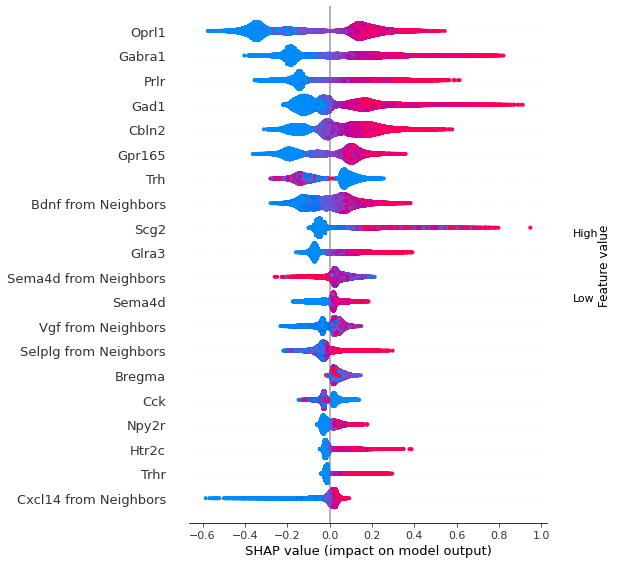

In [58]:
shap.summary_plot(shap_values, df)

In [59]:
sum(testY)

277212.00598051096